<a href="https://www.kaggle.com/code/dascient/yahoo-s-top-gainers-kalman-forecasting-model?scriptVersionId=150210596" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Information and market data collected from Yahoo - https://finance.yahoo.com/gainers/
## Please do not consider the recommendations below as valid. Trade at your own discretion. 

In [1]:
# source
# https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install plotly
!pip install yfinance
!pip install schedule
!pip install pykalman
!pip install pandas_ta
from IPython.display import clear_output
import plotly.graph_objects as go
import schedule,warnings,time,ast
from pykalman import KalmanFilter
import plotly.graph_objects as go
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from rich import print, pretty
from datetime import datetime
from random import randint
from random import seed
import pandas_ta as ta
import yfinance as yf
import pandas as pd
import numpy as np
import lxml.html
import requests
import os

clear_output()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def calculate_symbol(df):
    
    df['close'] = df['Close']
    df['low'] = df['Low']
    df['high'] = df['High']
    df['open'] = df['Open']
    
    close = df['close'][len(df)-1]
    low = df['low'][len(df)-1]

    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                      observation_matrices = [1],   # The value for Ht.
                      initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                      initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                      observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                      transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
    # Get the Kalman smoothing
    state_means, _ = kf.filter(df['close'].values)
    # Call it kf_mean
    df['kf_mean'] = np.array(state_means)
    kalman = df.kf_mean[len(df)-1]
    aboveKalman = low > kalman


    # exponential moving averages 
    ema_13 = df.ta.ema(13, append=True)[-1:].reset_index(drop=True)[0]
    ema_31 = df.ta.ema(31, append=True)[-1:].reset_index(drop=True)[0]
    ema_crossover = ema_13 > kalman


    # lower/upper 14-day bollinger bands for mean reversion
    bbl_14 = df.ta.bbands(length=14, append=True)[['BBL_14_2.0']].tail(1).values[0][0]
    bbu_14 = df.ta.bbands(length=14, append=True)[['BBU_14_2.0']].tail(1).values[0][0]
    bband_buy = close < bbl_14
    bband_sell = close > bbu_14


    # ichimoku 9 & 26-day forecasts 
    # https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.IchimokuIndicator
    isa_9 = df.ta.ichimoku()[1]['ISA_9'].tail(1).values[0] # help(ta.ichimoku)
    isb_26 = df.ta.ichimoku()[1]['ISB_26'].tail(1).values[0]


    # archer ma 
    # https://github.com/twopirllc/pandas-ta#general
    amat = (df.ta.amat()['AMATe_LR_8_21_2'].tail(1).values[0] == 1)


    # rsi
    rsi = df.ta.rsi()[len(df)-1]
    rsi_buy = rsi < 30
    rsi_sell = rsi > 70


    # choppy
    # https://github.com/twopirllc/pandas-ta#trend-18
    try: 
        chop = "{:.2f}".format(df.ta.chop()[len(df.ta.chop())-1]) 
    except RunTimeWarning:
        chop = 0


    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # signal
    #buy = (close < isa_9) & (close < isb_26) & amat & rsi_buy & bband_buy & aboveKalman
    
    # kalman is accounted for in the ema_crossover
    buy = amat & ema_crossover# & aboveKalman

    #sell = (close > isa_9) & (close > isb_26) & ~amat & rsi_sell & bband_sell & ~aboveKalman
    
    # kalman is accounted for in the ema_crossover
    sell = ~amat & ~ema_crossover# & ~aboveKalman
    
    return df, close, isa_9, isb_26, chop, rsi, amat, ema_crossover, buy, sell, aboveKalman

# plotter
def plot(df,symbol):
    fig = go.Figure(go.Candlestick(x=df.index,
                                   open=df['open'],
                                   high=df['high'],
                                   low=df['low'],
                                   close=df['close'],
                                   name=symbol,
                                  ))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['kf_mean'], 
                             opacity=0.7, 
                             line=dict(color='purple', width=2), 
                             name='Kalman Filter'))

    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_13'], 
                             opacity=0.7, 
                             line=dict(color='orange', width=2), 
                             name='EMA_13'))
    
    fig.add_trace(go.Scatter(x=df.index, 
                             y=df['EMA_31'], 
                             opacity=0.7, 
                             line=dict(color='lightblue', width=2), 
                             name='EMA_31 '))
    
    fig.update_layout(title=f'Ticker: {symbol}')
    fig.update_layout(xaxis_rangeslider_visible=False)
    return fig.show()

# [Fear & Greed Index](https://www.cnn.com/markets/fear-and-greed)

In [3]:
!pip install fear-and-greed
clear_output()

import fear_and_greed
#type(fear_and_greed.get())

print('\nIndex: ',fear_and_greed.get()[0])
print('Range: ',fear_and_greed.get()[1])
print('Datetime: ',fear_and_greed.get()[2])

Index:  42.2571428571429

Range:  fear

Datetime:  2023-11-10 23:59:50+00:00

# Today's Yahoo Gainers 
## Including Recommendations, Candlesticks, Closing Price, Ichimoku 9 & 26 Day Spans, Choppiness, RSI, Exponential Moving Averages (EMA) & Kalman Forecast Predictors. 
### This notebook only plots entry & exit stocks out of the 100 from Yahoo's Gainers webpage.

In [4]:
from datetime import datetime
today = pd.Timestamp(datetime.now(), tz='EST').strftime("%Y-%m-%d")
print(f"Calculating indicators for today's date: {today}.")

Calculating indicators for today's date: 2023-11-11.

# Entry Points

Entry Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: JHIUF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 29.0

Ichimoku 9-Day Forecast: 27.024999618530273

Ichimoku 26-Day Forecast: 27.024999618530273

Choppiness (%): 0.00

RSI: 95.03508288101094

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

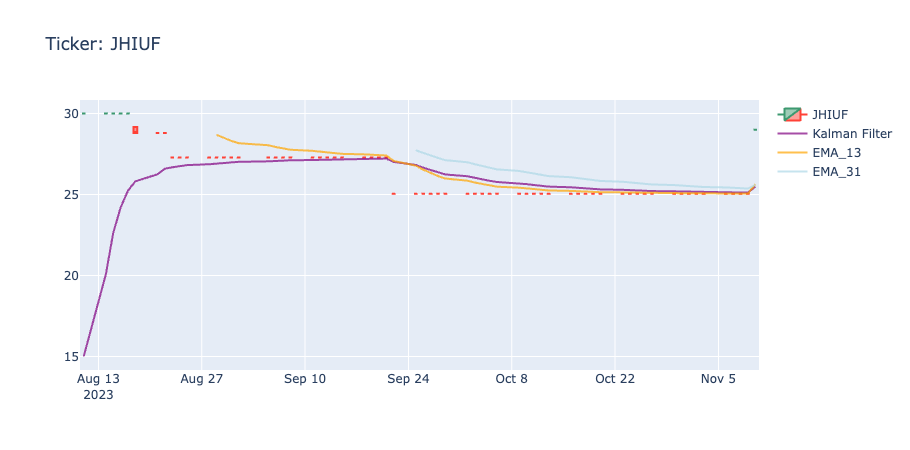

Ticker: LNW

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 86.81999969482422

Ichimoku 9-Day Forecast: 78.5

Ichimoku 26-Day Forecast: 77.28499984741211

Choppiness (%): 37.93

RSI: 74.21575689761055

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

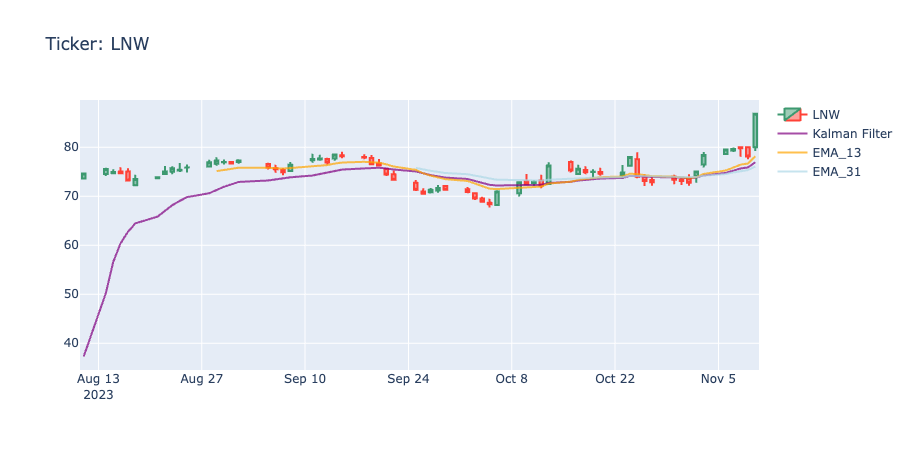

Ticker: SYNA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 98.01000213623047

Ichimoku 9-Day Forecast: 87.46999740600586

Ichimoku 26-Day Forecast: 87.46999740600586

Choppiness (%): 30.61

RSI: 65.11744248859455

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

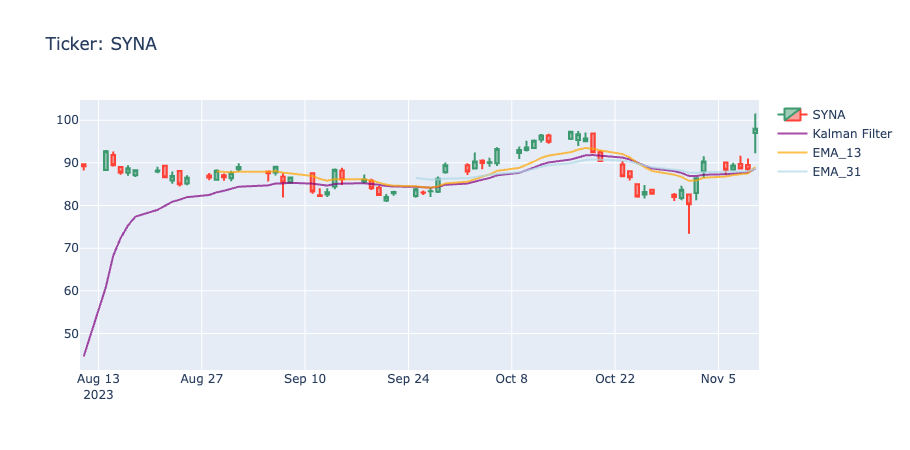

Ticker: ONTO

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 135.5500030517578

Ichimoku 9-Day Forecast: 125.64374923706055

Ichimoku 26-Day Forecast: 128.3474998474121

Choppiness (%): 36.35

RSI: 66.91916065319235

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: False

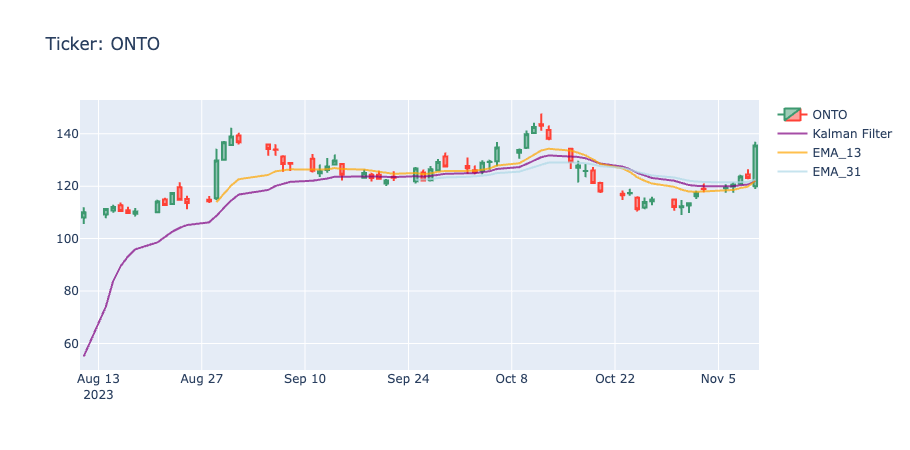

Ticker: STN

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 68.69999694824219

Ichimoku 9-Day Forecast: 64.51000022888184

Ichimoku 26-Day Forecast: 64.27499961853027

Choppiness (%): 30.31

RSI: 69.64200107812523

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

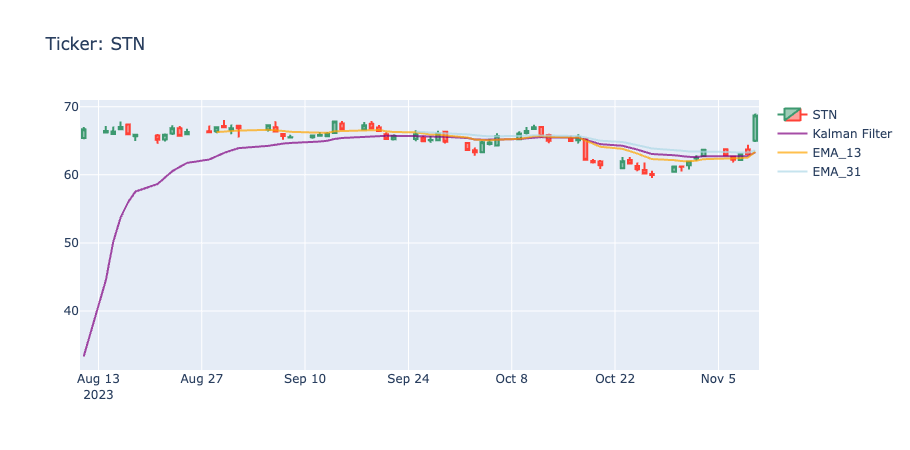

Ticker: PLTR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 19.670000076293945

Ichimoku 9-Day Forecast: 17.09999942779541

Ichimoku 26-Day Forecast: 16.699999809265137

Choppiness (%): 38.83

RSI: 67.53444880048356

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

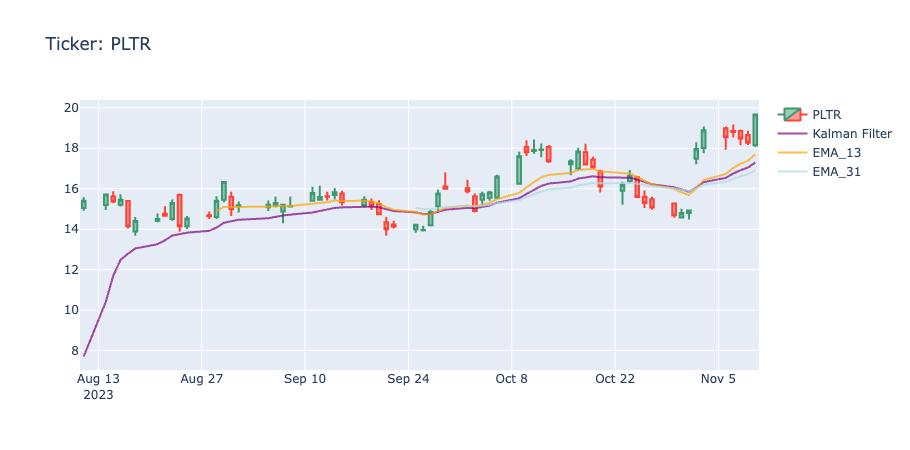

Ticker: CAMT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 64.29000091552734

Ichimoku 9-Day Forecast: 57.09749794006348

Ichimoku 26-Day Forecast: 56.814998626708984

Choppiness (%): 33.97

RSI: 67.65080250587413

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

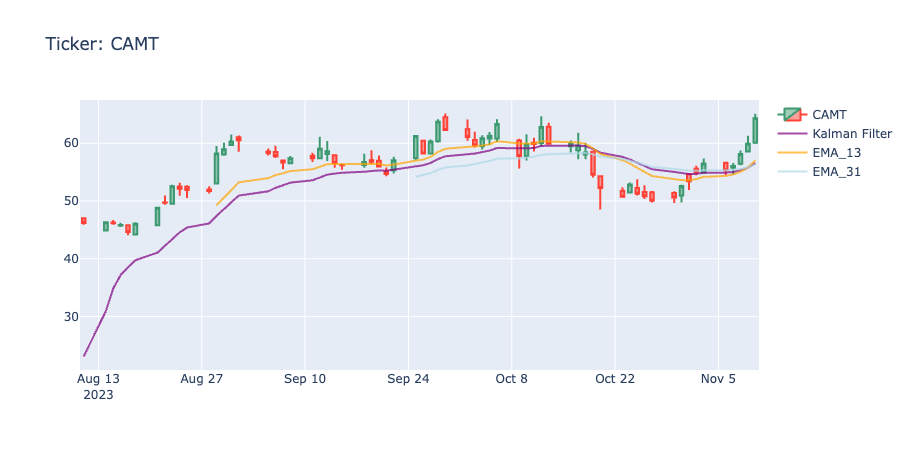

Ticker: HOLX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 72.12999725341797

Ichimoku 9-Day Forecast: 68.61749839782715

Ichimoku 26-Day Forecast: 70.47999954223633

Choppiness (%): 34.80

RSI: 65.53987083649143

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

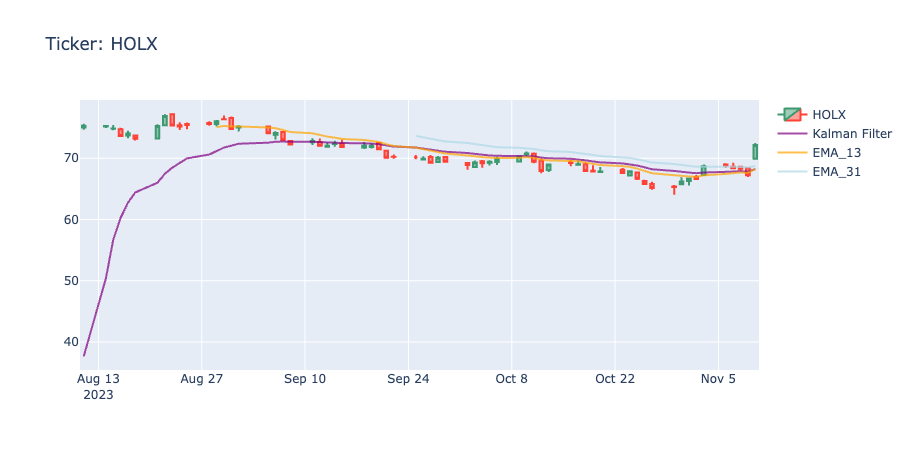

Ticker: TSM

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 97.44000244140625

Ichimoku 9-Day Forecast: 91.3499984741211

Ichimoku 26-Day Forecast: 90.8849983215332

Choppiness (%): 34.94

RSI: 69.36478768602748

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

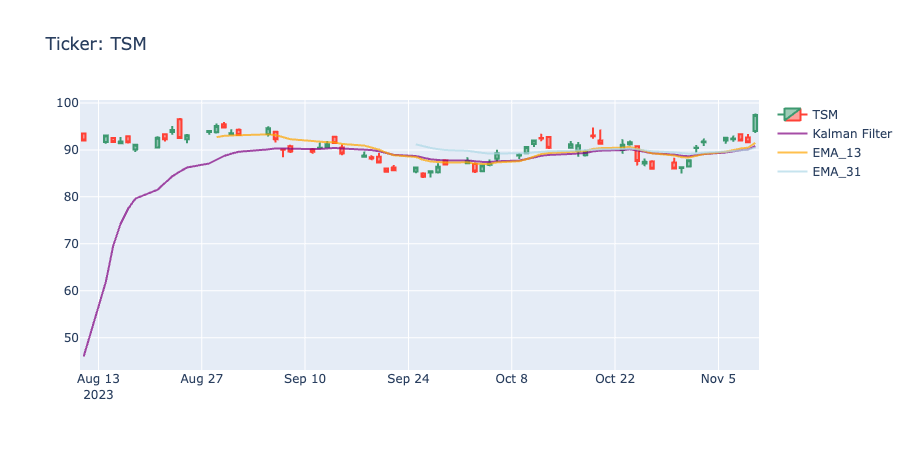

Ticker: RMBS

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 62.689998626708984

Ichimoku 9-Day Forecast: 55.91499996185303

Ichimoku 26-Day Forecast: 55.635000228881836

Choppiness (%): 39.27

RSI: 63.78981254996553

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

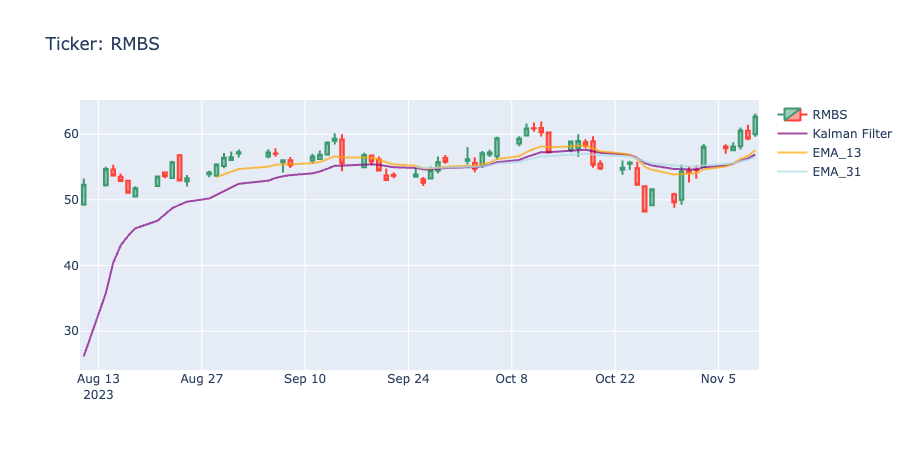

Ticker: KLAC

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 534.25

Ichimoku 9-Day Forecast: 493.78250885009766

Ichimoku 26-Day Forecast: 488.14500427246094

Choppiness (%): 34.49

RSI: 73.81282384205478

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

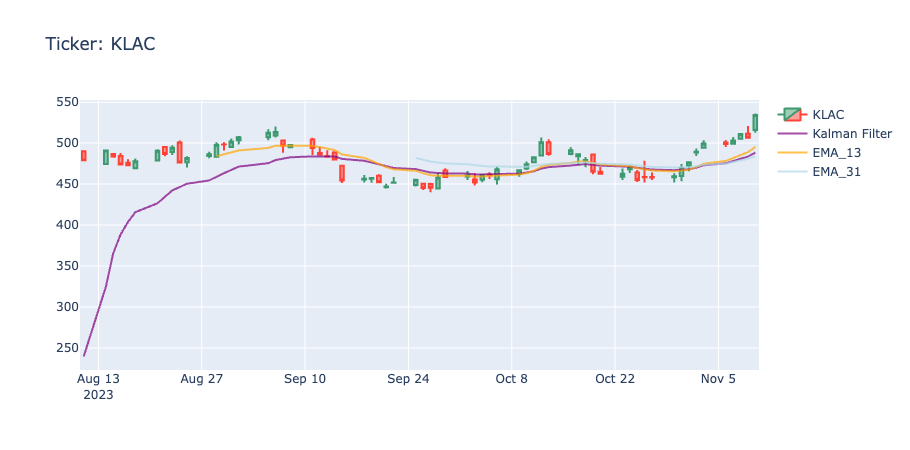

Ticker: LRCX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 685.4299926757812

Ichimoku 9-Day Forecast: 631.1300048828125

Ichimoku 26-Day Forecast: 643.1649780273438

Choppiness (%): 30.04

RSI: 72.64280458809397

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

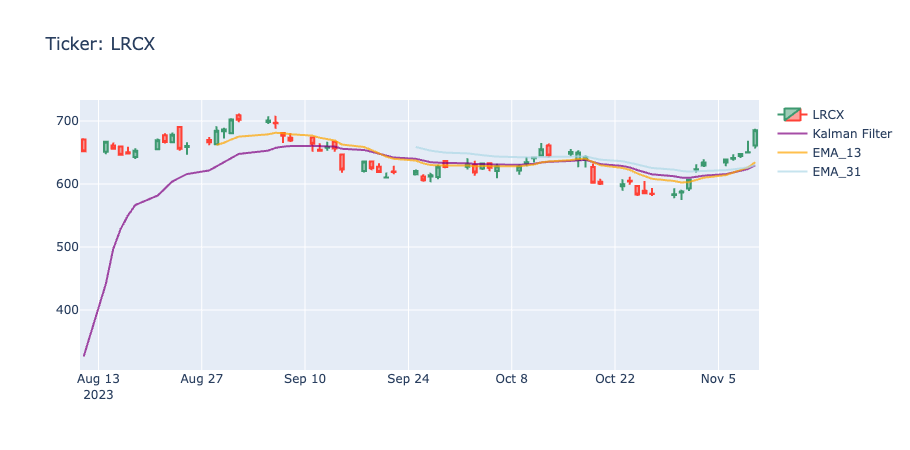

Ticker: TOELY

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 76.02999877929688

Ichimoku 9-Day Forecast: 70.46250057220459

Ichimoku 26-Day Forecast: 70.03000068664551

Choppiness (%): 36.57

RSI: 71.1890957080868

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

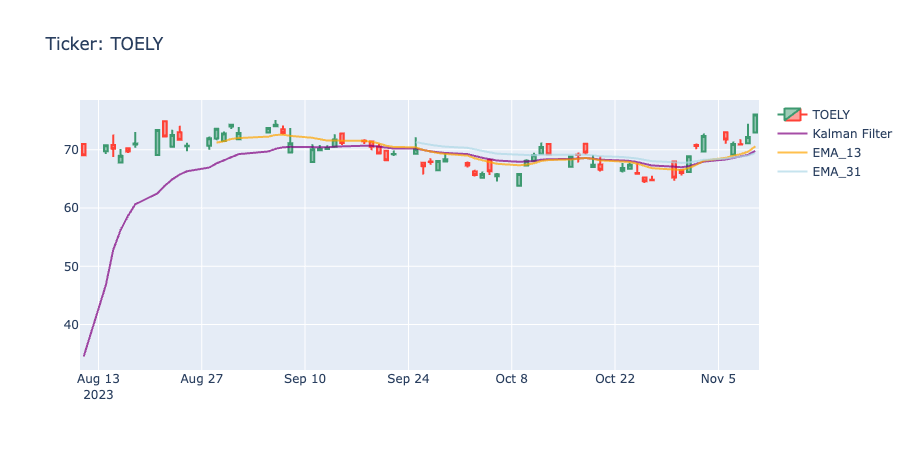

Ticker: AMAT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 150.67999267578125

Ichimoku 9-Day Forecast: 140.10000610351562

Ichimoku 26-Day Forecast: 142.23500061035156

Choppiness (%): 31.96

RSI: 71.14141099899184

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

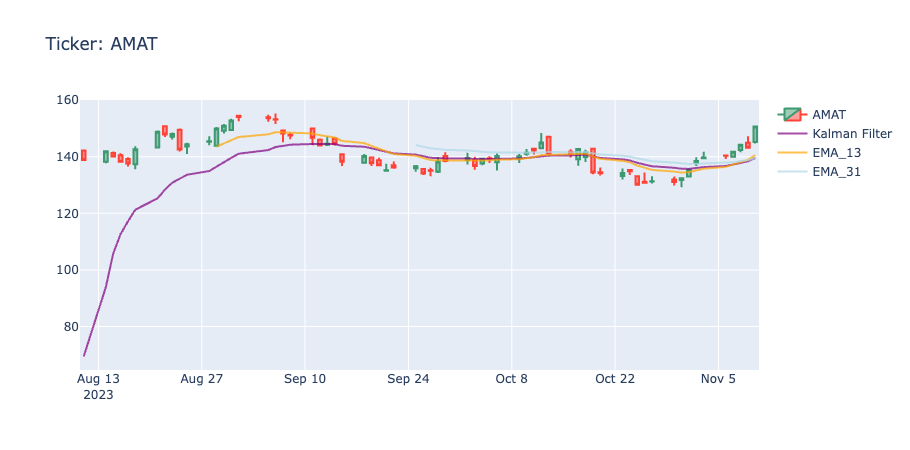

Ticker: AVGO

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 957.52001953125

Ichimoku 9-Day Forecast: 890.5549926757812

Ichimoku 26-Day Forecast: 877.02001953125

Choppiness (%): 31.98

RSI: 72.08769045135124

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

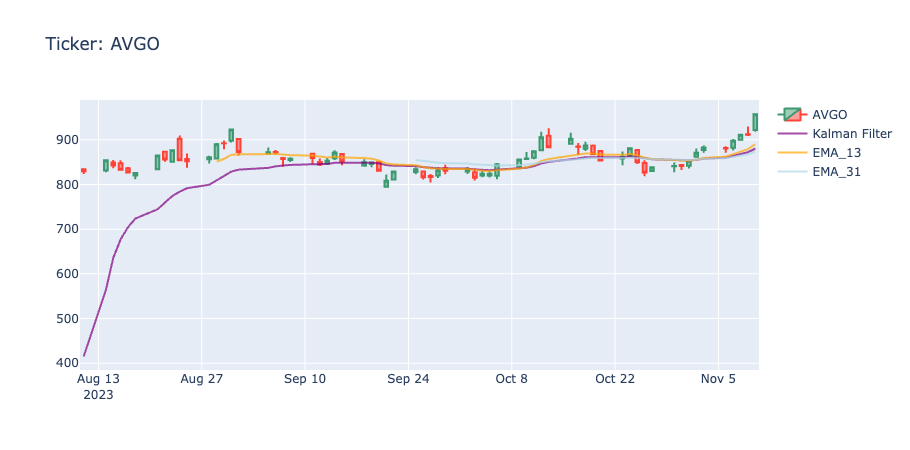

Ticker: NVMI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 111.75

Ichimoku 9-Day Forecast: 102.4325008392334

Ichimoku 26-Day Forecast: 111.04999542236328

Choppiness (%): 27.17

RSI: 67.35320478854533

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

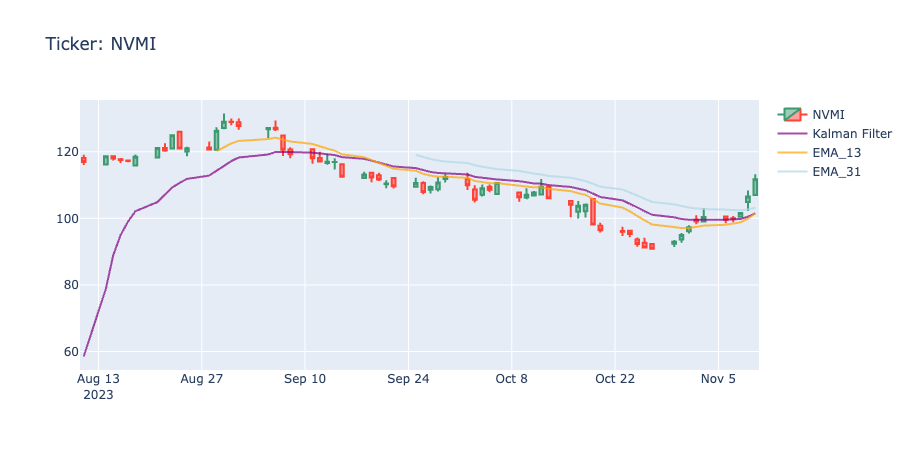

Ticker: MPWR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 504.5799865722656

Ichimoku 9-Day Forecast: 455.31249237060547

Ichimoku 26-Day Forecast: 464.24501037597656

Choppiness (%): 34.07

RSI: 64.03961418872609

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

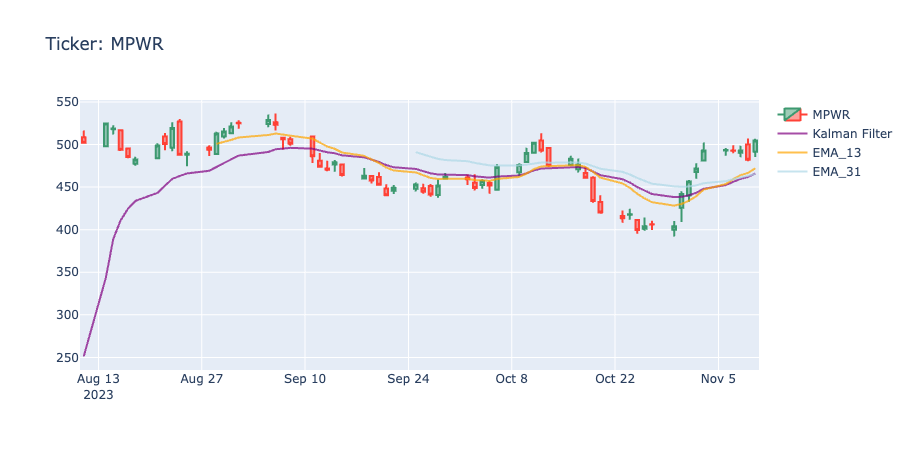

Ticker: AMD

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 118.58999633789062

Ichimoku 9-Day Forecast: 106.64749908447266

Ichimoku 26-Day Forecast: 106.40999984741211

Choppiness (%): 31.12

RSI: 70.93076075680854

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

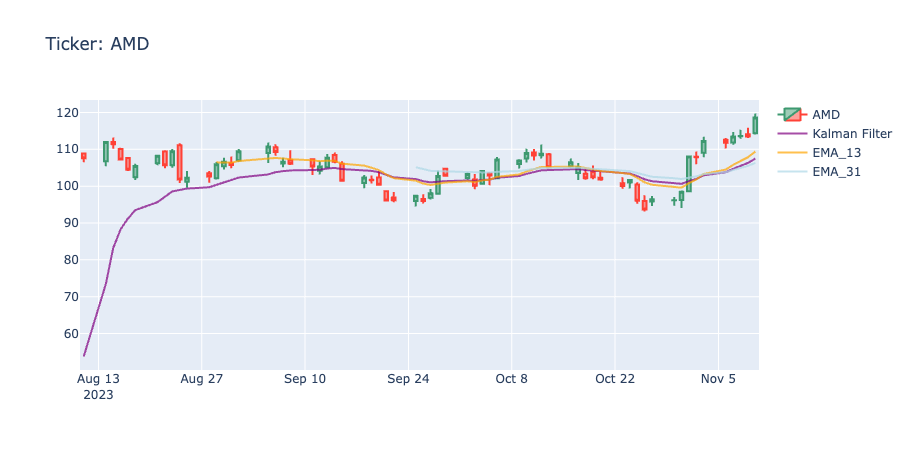

Ticker: RGA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 162.14999389648438

Ichimoku 9-Day Forecast: 153.02749633789062

Ichimoku 26-Day Forecast: 148.875

Choppiness (%): 39.90

RSI: 74.31711097581234

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

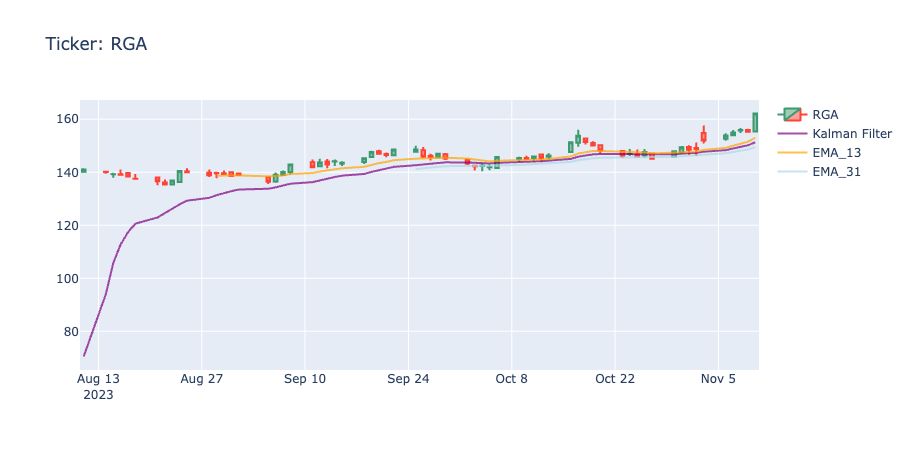

Ticker: EXPE

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 118.68000030517578

Ichimoku 9-Day Forecast: 106.82500076293945

Ichimoku 26-Day Forecast: 106.82500076293945

Choppiness (%): 31.84

RSI: 68.62212389659412

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

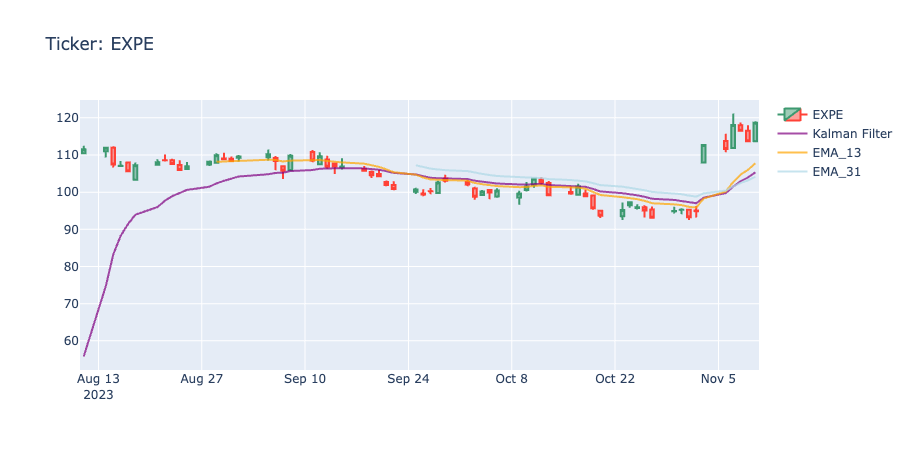

Ticker: CPRT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 48.72999954223633

Ichimoku 9-Day Forecast: 45.77680015563965

Ichimoku 26-Day Forecast: 45.6693000793457

Choppiness (%): 29.45

RSI: 72.94804403383104

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

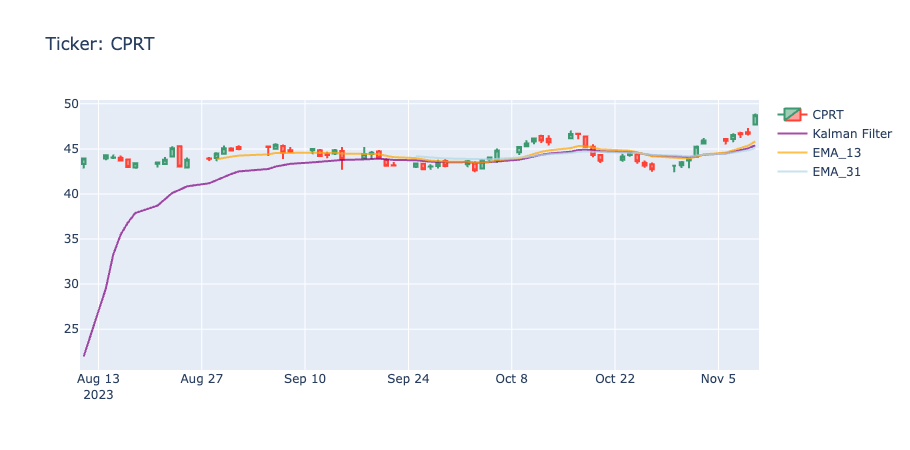

Ticker: AMKR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 23.920000076293945

Ichimoku 9-Day Forecast: 20.824999809265137

Ichimoku 26-Day Forecast: 23.06999969482422

Choppiness (%): 29.19

RSI: 60.23558054744581

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

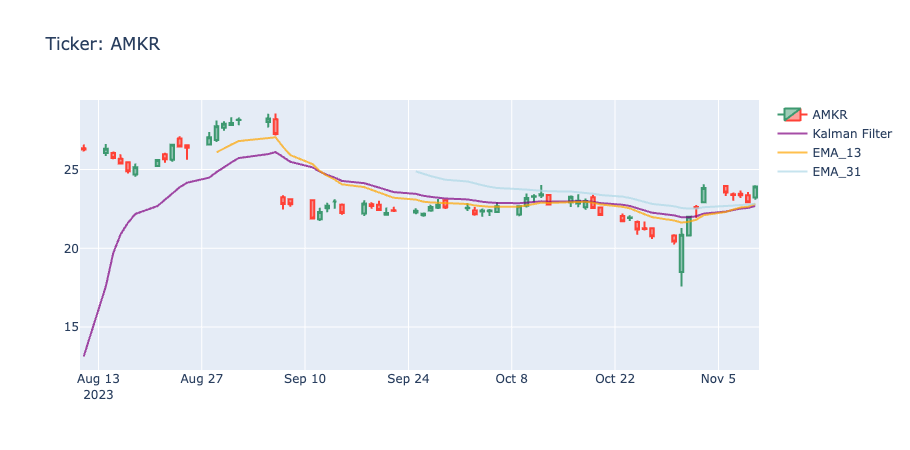

Ticker: ASML

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 661.280029296875

Ichimoku 9-Day Forecast: 623.4649810791016

Ichimoku 26-Day Forecast: 619.2699890136719

Choppiness (%): 35.88

RSI: 68.74742455329806

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

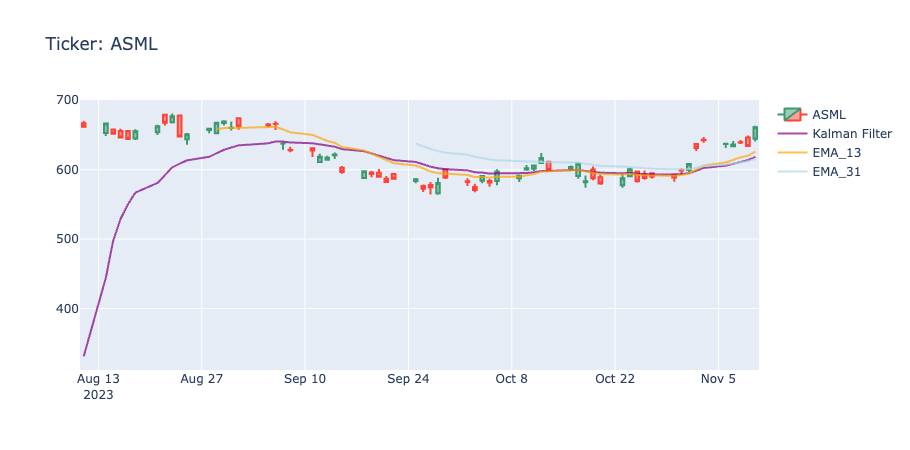

Ticker: DUOL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 211.52999877929688

Ichimoku 9-Day Forecast: 178.99500274658203

Ichimoku 26-Day Forecast: 178.66000366210938

Choppiness (%): 25.01

RSI: 77.27064559416567

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

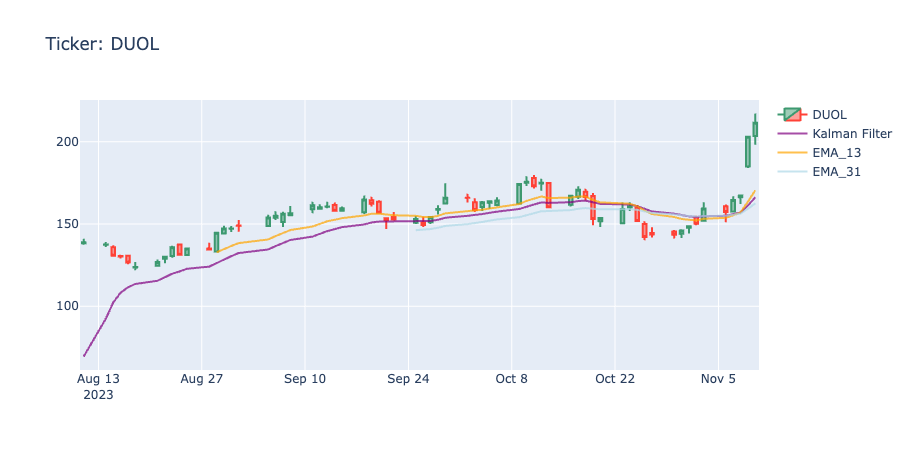

Ticker: ELAN

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 10.680000305175781

Ichimoku 9-Day Forecast: 9.752500057220459

Ichimoku 26-Day Forecast: 10.570000171661377

Choppiness (%): 39.96

RSI: 59.59420383067863

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

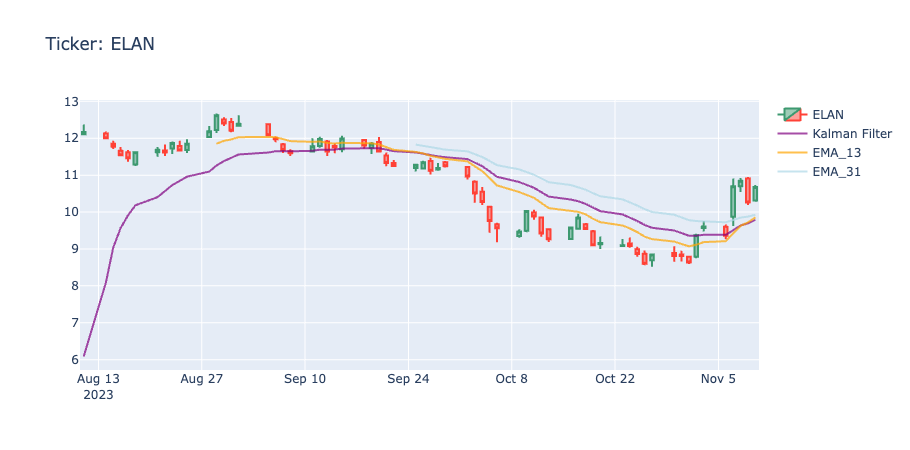

In [5]:
# Plotly within a double nested for-loop. 
# This pulls from Yahoo's Gainers first page, then implements technical indicators to output forecasts, 
# RSI, choppiness, trend archers, & other conditionals to aid in decision making.

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Pull Yahoo's Top Gainers of Today - first page.

url = 'https://finance.yahoo.com/gainers?count=100&offset=0'
headers = {
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'
}

ytext = requests.get(url,headers=headers).text
yroot = lxml.html.fromstring(ytext)
List = []
for x in yroot.xpath('//*[@id="fin-scr-res-table"]//a'):
    List.append({"top_movers":x.attrib['href'].split("/")[-1].split("?")[0]})
List = pd.DataFrame(List)

# calculating plotter
print('\n Entry Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[8] == True) & (calculate_symbol(v)[4]<="40"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Exit Points

Exit Points

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Ticker: U

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 27.010000228881836

Ichimoku 9-Day Forecast: 26.137500286102295

Ichimoku 26-Day Forecast: 31.125

Choppiness (%): 52.49

RSI: 47.70193608113749

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

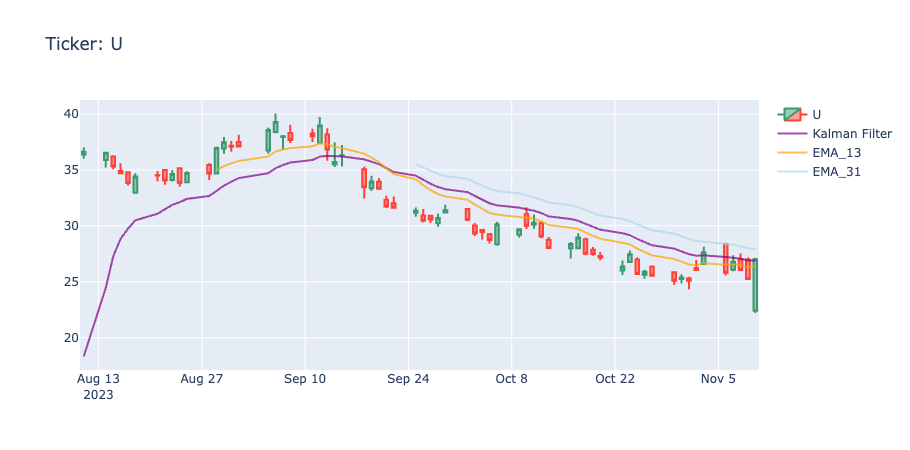

Ticker: POWI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 73.08999633789062

Ichimoku 9-Day Forecast: 72.10250091552734

Ichimoku 26-Day Forecast: 76.47999954223633

Choppiness (%): 54.98

RSI: 50.094697834257374

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

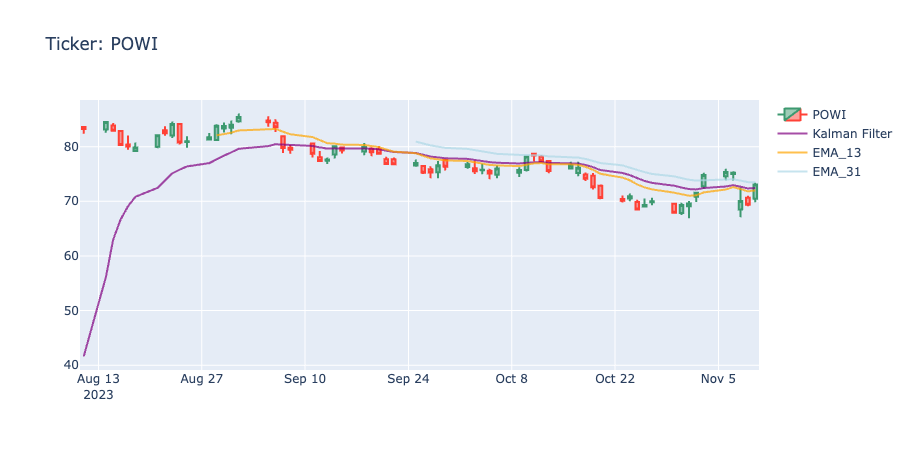

Ticker: BMRPF

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 6.6020002365112305

Ichimoku 9-Day Forecast: 6.569999933242798

Ichimoku 26-Day Forecast: 6.827999830245972

Choppiness (%): 70.19

RSI: 49.20648868699148

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

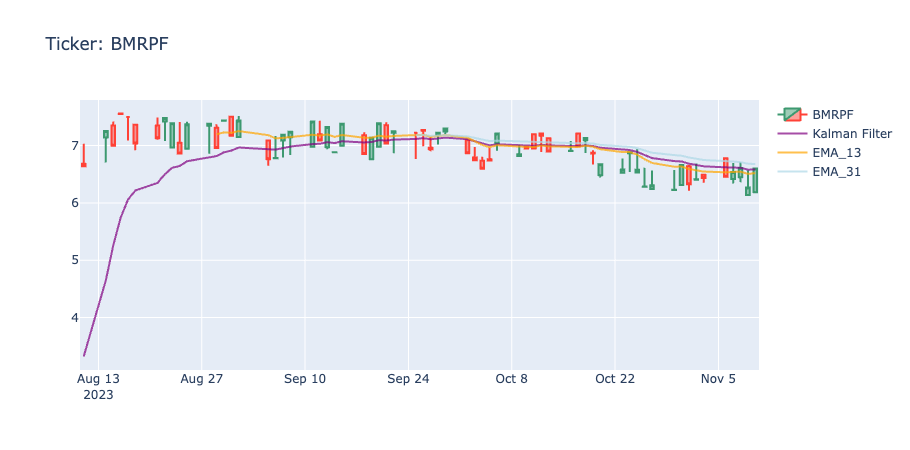

Ticker: AEIS

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 89.44999694824219

Ichimoku 9-Day Forecast: 90.36499977111816

Ichimoku 26-Day Forecast: 100.77000045776367

Choppiness (%): 55.92

RSI: 45.16080923913705

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

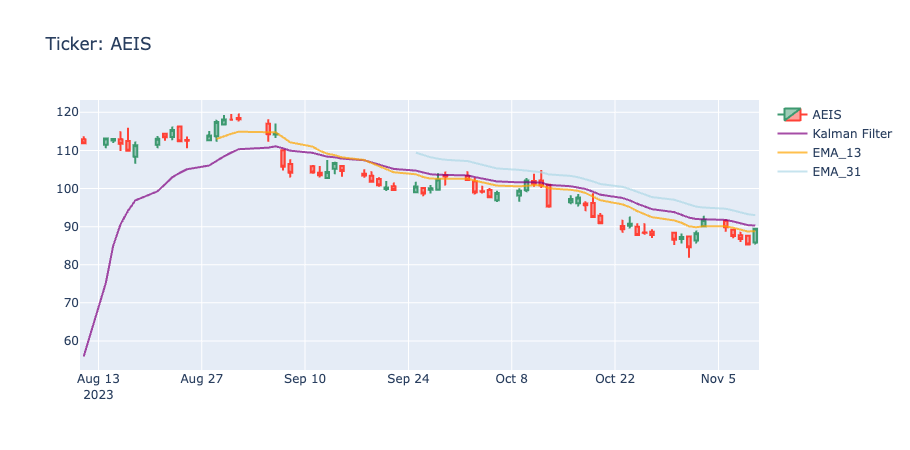

Ticker: IMVT

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 32.630001068115234

Ichimoku 9-Day Forecast: 34.221750259399414

Ichimoku 26-Day Forecast: 31.844999313354492

Choppiness (%): 60.22

RSI: 47.64430791563868

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

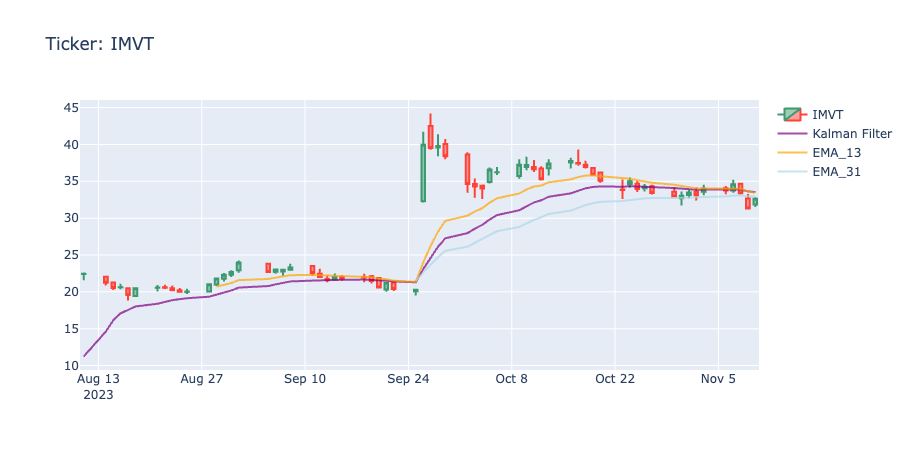

Ticker: NWTN

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 8.140000343322754

Ichimoku 9-Day Forecast: 8.534999966621399

Ichimoku 26-Day Forecast: 8.675000190734863

Choppiness (%): 60.34

RSI: 42.76994183780158

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

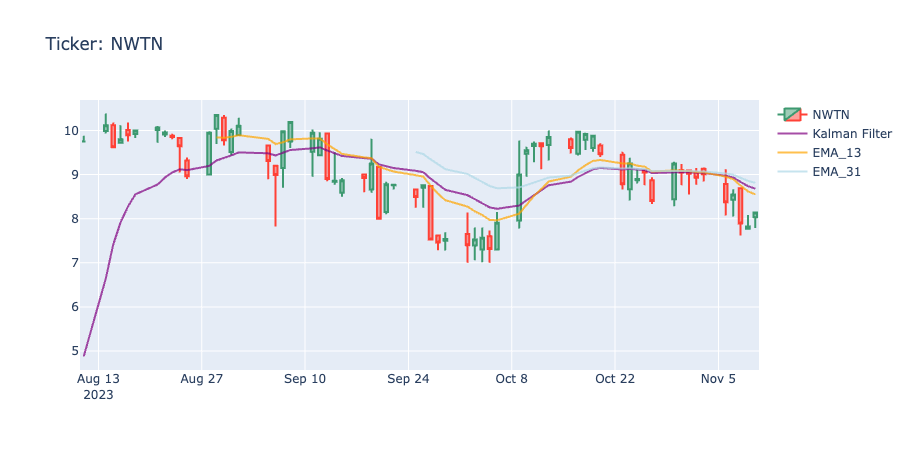

Ticker: SWKS

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 90.02999877929688

Ichimoku 9-Day Forecast: 90.32499694824219

Ichimoku 26-Day Forecast: 97.55999755859375

Choppiness (%): 63.89

RSI: 45.55023606984995

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

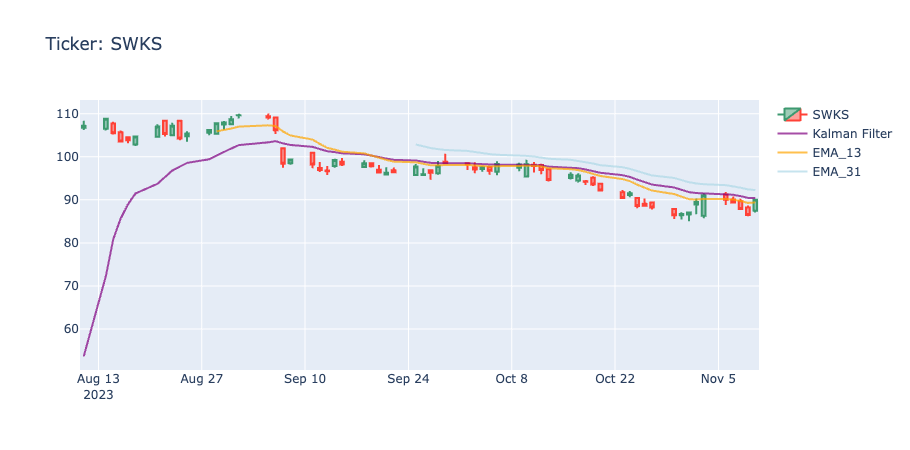

In [6]:
print('\n Exit Points')
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for i,v in List.top_movers.items()]:
    try:
        #calculate_symbol(v)
        if (calculate_symbol(v)[9] == True) & (calculate_symbol(v)[4] >= "50"):
            print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness >= 50):',calculate_symbol(v)[8])
            print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
            print('\n\nClose:',calculate_symbol(v)[1])
            print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
            print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
            print('Choppiness (%):',calculate_symbol(v)[4])
            print('RSI:',calculate_symbol(v)[5])
            print('Archer MA Trending:',calculate_symbol(v)[6])
            print('EMA_13 > Kalman:',calculate_symbol(v)[7])
            print('Low > Kalman:',calculate_symbol(v)[10])
            plot(v.tail(90),i)
        else:pass
    except:pass

# Portfolio

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Ticker: AAPL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 186.39999389648438

Ichimoku 9-Day Forecast: 176.6775016784668

Ichimoku 26-Day Forecast: 177.8249969482422

Choppiness (%): 29.86

RSI: 69.31691941706742

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

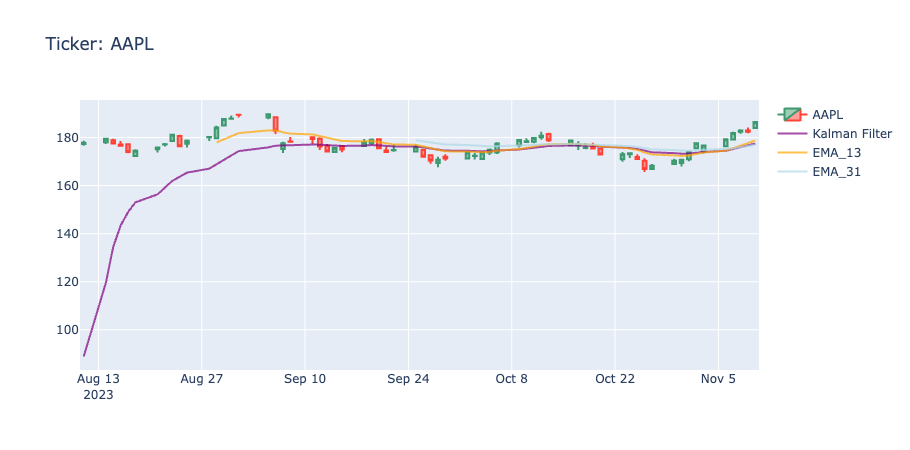

Ticker: AI

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 26.719999313354492

Ichimoku 9-Day Forecast: 26.320000648498535

Ichimoku 26-Day Forecast: 27.96000099182129

Choppiness (%): 54.72

RSI: 52.6615075218928

Archer MA Trending: False

EMA_13 > Kalman: True

Low > Kalman: False

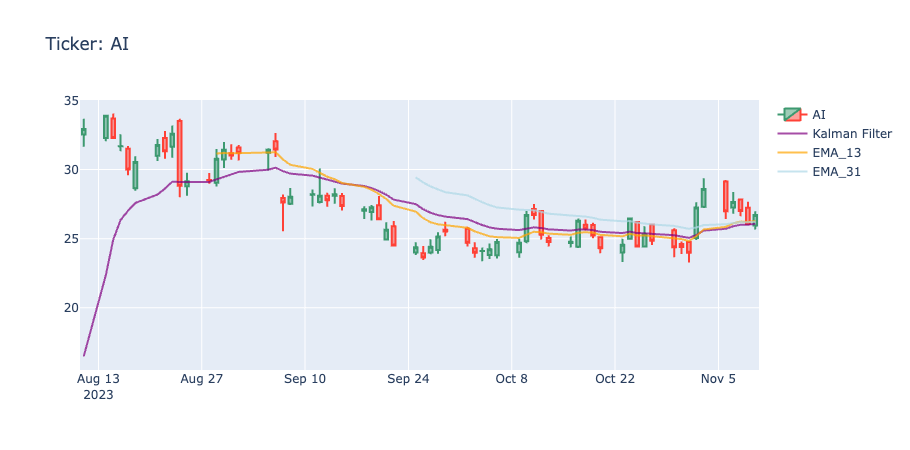

Ticker: FCEL

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 1.0299999713897705

Ichimoku 9-Day Forecast: 1.1800000071525574

Ichimoku 26-Day Forecast: 1.2649999856948853

Choppiness (%): 55.38

RSI: 39.58446561119209

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

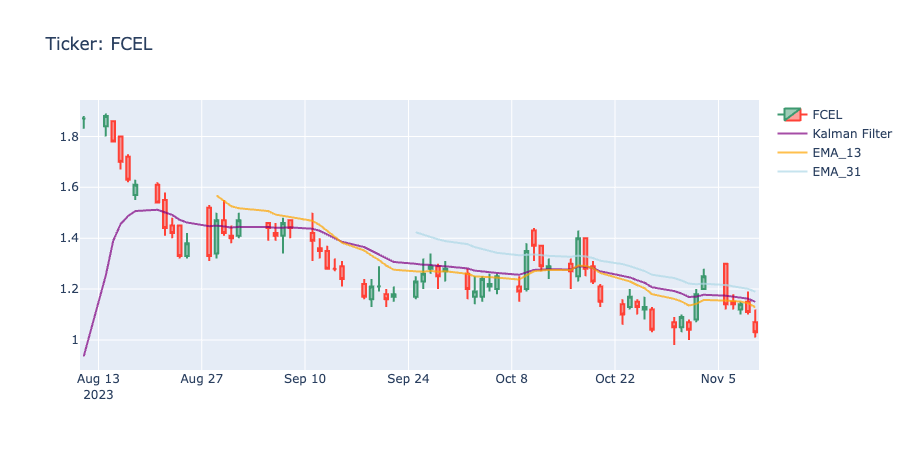

Ticker: FSR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 3.8399999141693115

Ichimoku 9-Day Forecast: 4.692500114440918

Ichimoku 26-Day Forecast: 5.365000128746033

Choppiness (%): 36.14

RSI: 27.61183917259891

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

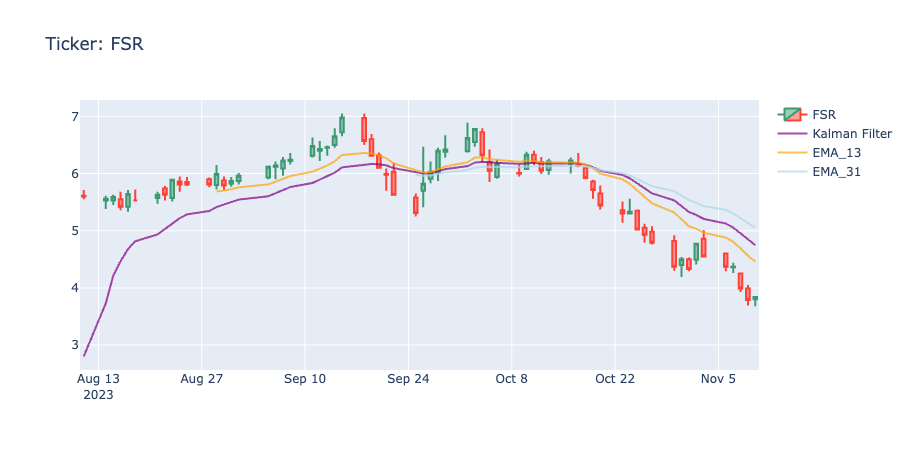

Ticker: NOC

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 463.2699890136719

Ichimoku 9-Day Forecast: 461.40250396728516

Ichimoku 26-Day Forecast: 455.7250061035156

Choppiness (%): 47.37

RSI: 47.648883692686475

Archer MA Trending: False

EMA_13 > Kalman: True

Low > Kalman: False

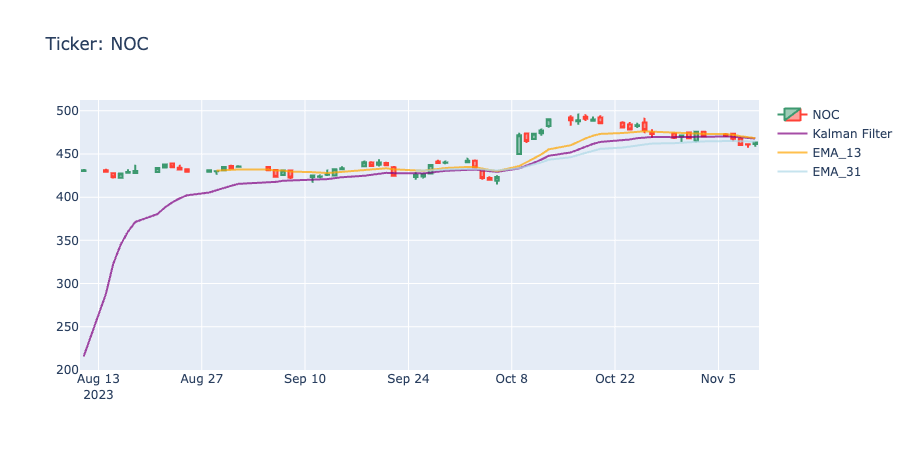

Ticker: PLTR

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 19.670000076293945

Ichimoku 9-Day Forecast: 17.09999942779541

Ichimoku 26-Day Forecast: 16.699999809265137

Choppiness (%): 38.83

RSI: 67.53444880048356

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

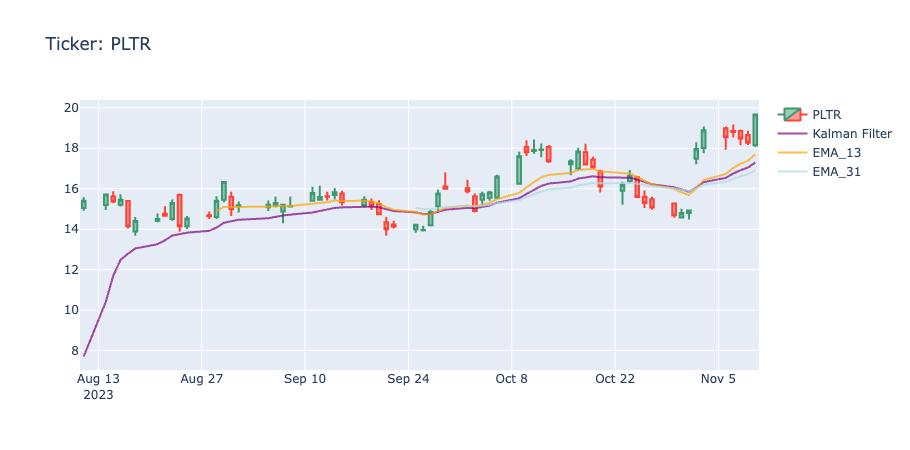

Ticker: SBUX

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): True

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): False

Close: 104.33000183105469

Ichimoku 9-Day Forecast: 97.68500137329102

Ichimoku 26-Day Forecast: 97.01499938964844

Choppiness (%): 33.26

RSI: 69.55158421560365

Archer MA Trending: True

EMA_13 > Kalman: True

Low > Kalman: True

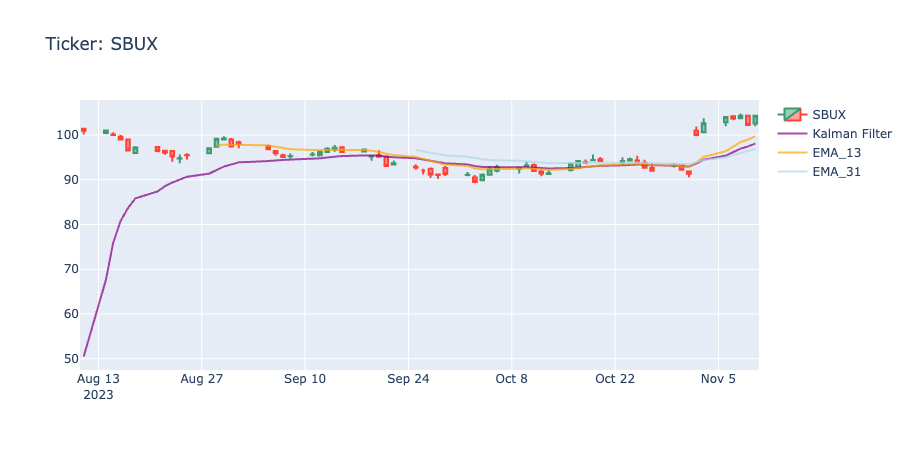

Ticker: TSLA

 "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40): False

"Exit Point"  ~AMAT & ~(EMA_13 > Kalman): True

Close: 214.64999389648438

Ichimoku 9-Day Forecast: 220.8625030517578

Ichimoku 26-Day Forecast: 236.52500915527344

Choppiness (%): 55.40

RSI: 42.43485714378621

Archer MA Trending: False

EMA_13 > Kalman: False

Low > Kalman: False

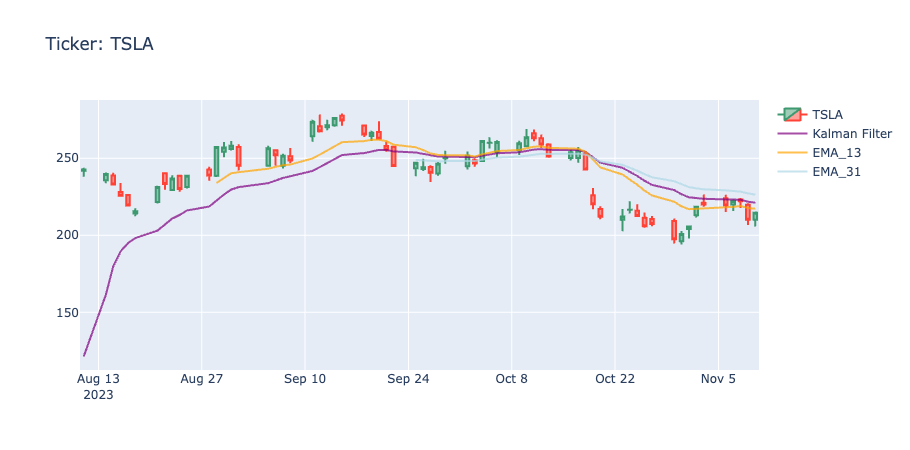

In [17]:
# calculating plotter
Portfolio = ['AAPL','AI','FCEL','FSR','NOC','PLTR','SBUX','TSLA']
for i,v in [(v,yf.download(tickers=v, period='3mo', interval='1d')) for v in Portfolio]: 
    print(f'\n\nTicker: {i}\n\n "Entry Point"  AMAT &  (EMA_13 > Kalman) & (Choppiness <= 40):',calculate_symbol(v)[8])
    print(' "Exit Point"  ~AMAT & ~(EMA_13 > Kalman):',calculate_symbol(v)[9])
    print('\n\nClose:',calculate_symbol(v)[1])
    print('Ichimoku 9-Day Forecast:',calculate_symbol(v)[2])
    print('Ichimoku 26-Day Forecast:',calculate_symbol(v)[3])
    print('Choppiness (%):',calculate_symbol(v)[4])
    print('RSI:',calculate_symbol(v)[5])
    print('Archer MA Trending:',calculate_symbol(v)[6])
    print('EMA_13 > Kalman:',calculate_symbol(v)[7])
    print('Low > Kalman:',calculate_symbol(v)[10])
    plot(v.tail(90),i)
else:pass

In [7]:
# choppiness
print("Choppiness:")
help(ta.chop)

Choppiness:

Help on function chop in module pandas_ta.trend.chop:

chop(high, low, close, length=None, atr_length=None, ln=None, scalar=None, drift=None, offset=None, **kwargs)
    Choppiness Index (CHOP)
    
    The Choppiness Index was created by Australian commodity trader
    E.W. Dreiss and is designed to determine if the market is choppy
    (trading sideways) or not choppy (trading within a trend in either
    direction). Values closer to 100 implies the underlying is choppier
    whereas values closer to 0 implies the underlying is trending.
    
    Sources:
        https://www.tradingview.com/scripts/choppinessindex/
        https://www.motivewave.com/studies/choppiness_index.htm
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        HH = high.rolling(length).max()
        LL = low.rolling(length).min()
    
        ATR_SUM = SUM(ATR(drift), length)
        CHOP = scalar * (LOG10(ATR_SUM) - LOG10(HH - LL))
        CHOP /= LOG10(length)
    
    

In [ ]:
# soon to incorporate this charting method: https://github.com/twopirllc/pandas-ta/blob/main/examples/example.ipynb

In [ ]:
# en fin

## Disclaimer

All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.
